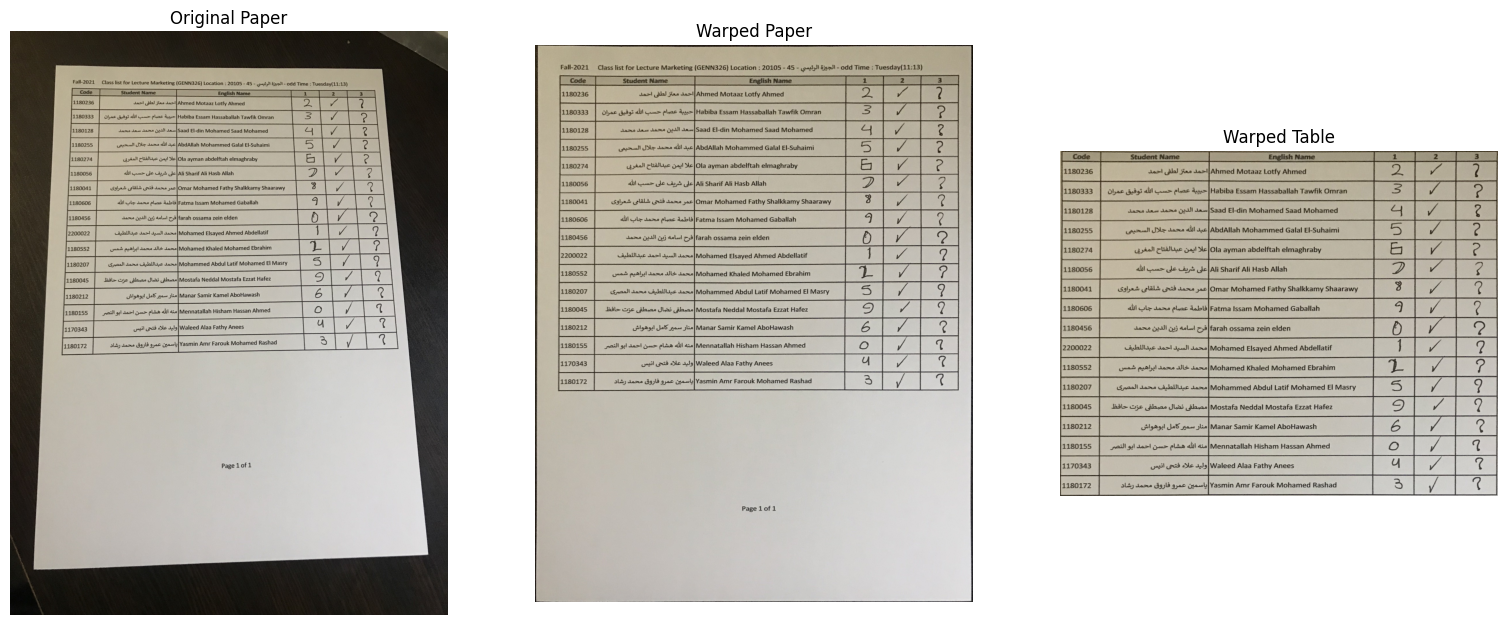

In [48]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from utils import *  # assumes show_images function exists

# ------------------ 1️⃣ Load image ------------------
image_path = "../data/9.jpg"  # Replace with your image path
image = cv.imread(image_path)
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

# ------------------ 2️⃣ Paper detection ------------------
gray = cv.cvtColor(image_rgb, cv.COLOR_RGB2GRAY)
blur = cv.GaussianBlur(gray, (7,7), 0)
thresh = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 15, 2)

contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Find the largest 4-sided contour -> paper
four_sided = []
for cnt in contours:
    area = cv.contourArea(cnt)
    peri = cv.arcLength(cnt, True)
    approx = cv.approxPolyDP(cnt, 0.02*peri, True)
    if len(approx) == 4:
        four_sided.append((area, approx))

if not four_sided:
    raise ValueError("No paper detected!")

four_sided = sorted(four_sided, key=lambda x: x[0], reverse=True)
paper_contour = four_sided[0][1]  # largest 4-sided contour

# Warp the paper
pts = paper_contour.reshape(4,2).astype("float32")
# Order points: top-left, top-right, bottom-right, bottom-left
s = pts.sum(axis=1)
top_left = pts[np.argmin(s)]
bottom_right = pts[np.argmax(s)]
diff = np.diff(pts, axis=1)
top_right = pts[np.argmin(diff)]
bottom_left = pts[np.argmax(diff)]
ordered_pts = np.array([top_left, top_right, bottom_right, bottom_left], dtype="float32")

# Width & height
widthA = np.linalg.norm(bottom_right - bottom_left)
widthB = np.linalg.norm(top_right - top_left)
maxWidth = int(max(widthA, widthB))
heightA = np.linalg.norm(top_right - bottom_right)
heightB = np.linalg.norm(top_left - bottom_left)
maxHeight = int(max(heightA, heightB))

dst = np.array([[0,0],[maxWidth-1,0],[maxWidth-1,maxHeight-1],[0,maxHeight-1]], dtype="float32")
M = cv.getPerspectiveTransform(ordered_pts, dst)
paper_image = cv.warpPerspective(image_rgb, M, (maxWidth, maxHeight))

# ------------------ 3️⃣ Table detection ------------------
# Convert to gray and threshold
paper_gray = cv.cvtColor(paper_image, cv.COLOR_RGB2GRAY)
paper_blur = cv.GaussianBlur(paper_gray, (7,7), 0)
thresh_table = cv.adaptiveThreshold(paper_blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 15, 2)

# Morphology to extract lines
vertical_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, paper_image.shape[1]//100))
vertical_lines = cv.erode(thresh_table, vertical_kernel, iterations=3)
vertical_lines = cv.dilate(vertical_lines, vertical_kernel, iterations=3)

horizontal_kernel = cv.getStructuringElement(cv.MORPH_RECT, (paper_image.shape[1]//100, 1))
horizontal_lines = cv.erode(thresh_table, horizontal_kernel, iterations=3)
horizontal_lines = cv.dilate(horizontal_lines, horizontal_kernel, iterations=3)

# Combine lines to get table mask
table_mask = cv.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
table_mask = cv.erode(table_mask, cv.getStructuringElement(cv.MORPH_RECT, (2,2)), iterations=2)

# ------------------ 4️⃣ Find table contour ------------------
contours, _ = cv.findContours(table_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
if not contours:
    raise ValueError("No table detected!")

# Largest contour in table mask is table
table_contour = max(contours, key=cv.contourArea)

# Warp the table
rect = cv.minAreaRect(table_contour)
box = cv.boxPoints(rect)
box = np.array(box, dtype="float32")
s = box.sum(axis=1)
tl = box[np.argmin(s)]
br = box[np.argmax(s)]
diff = np.diff(box, axis=1)
tr = box[np.argmin(diff)]
bl = box[np.argmax(diff)]
ordered_box = np.array([tl, tr, br, bl], dtype="float32")

widthA = np.linalg.norm(br - bl)
widthB = np.linalg.norm(tr - tl)
maxWidth = int(max(widthA, widthB))
heightA = np.linalg.norm(tr - br)
heightB = np.linalg.norm(tl - bl)
maxHeight = int(max(heightA, heightB))

dst = np.array([[0,0],[maxWidth-1,0],[maxWidth-1,maxHeight-1],[0,maxHeight-1]], dtype="float32")
M = cv.getPerspectiveTransform(ordered_box, dst)
table_image = cv.warpPerspective(paper_image, M, (maxWidth, maxHeight))

# ------------------ 5️⃣ Show results ------------------
show_images([image_rgb, paper_image, table_image],
            titles=["Original Paper", "Warped Paper", "Warped Table"])
